In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import csv
from PIL import Image
import shutil
from tqdm import tqdm
import torch

from utils.utils0 import tensor_affine_transform, transform_to_displacement_field
from utils.utils1 import transform_points_DVF, ModelParams
from utils.SuperPoint import SuperPointFrontend, PointTracker
from utils.datagen import datagen

nn_thresh = 0.7
superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=nn_thresh, cuda=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data
data = pd.read_csv('Dataset/dataset_eye_actual_full.csv')


In [8]:
# take data with 'training' = 0
data = data[data['training'] == 0]

In [9]:
data.head()

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory
9,9,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
10,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
11,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
12,12,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b
13,13,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b


In [10]:
data.shape

(763, 10)

In [11]:
# add columns 'keypoints', 'mse', 'tre'
data['keypoints'] = 0
data['mse'] = 0
data['tre'] = 0

# calculate the keypoints, mse, tre
for i in range(data.shape[0]):
    # keypoints = 0
    mse = 0
    tre = 0
    # read image file from column 'source' and 'target'
    source = cv2.imread(data['source'].iloc[i], 0)
    target = cv2.imread(data['target'].iloc[i], 0)
    source = cv2.resize(source, (256, 256), interpolation=cv2.INTER_AREA)
    target = cv2.resize(target, (256, 256), interpolation=cv2.INTER_AREA)
    source = (source / np.max(source)).astype(np.float32)
    target = (target / np.max(target)).astype(np.float32)

    points1, desc1, heatmap1 = superpoint(source)
    points2, desc2, heatmap2 = superpoint(target)

    tracker = PointTracker(5, nn_thresh=0.7)
    try:
        matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=nn_thresh)
    except:
        print('No matches found')
        # TODO: find a better way to do this
        pass

    matches1 = np.array(points1[:2, matches[0, :].astype(int)])
    matches2 = np.array(points2[:2, matches[1, :].astype(int)])

    # calculate MSE
    mse = np.mean((source - target) ** 2)
    # calculate TRE
    tre = np.sqrt(np.sum((matches1 - matches2) ** 2))

    # save keypoints, mse, tre to the dataframe
    data['keypoints'][i] = matches1.shape[1]
    data['mse'][i] = mse
    data['tre'][i] = tre

data.head()

/tmp/ipykernel_10855/2831519236.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['keypoints'][i] = matches1.shape[1]
/tmp/ipykernel_10855/2831519236.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mse'][i] = mse
/tmp/ipykernel_10855/2831519236.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tre'][i] = tre
/tmp/ipykernel_10855/2831519236.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,mse,tre
9,9,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,222,0.009986,253.414680
10,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,175,0.011933,250.625218
11,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,227,0.011157,269.280523
12,12,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,57,0.028802,386.490621
13,13,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,78,0.072867,720.040971


In [17]:
# drop the rows with mse < 0.01
data_cut = data[data['mse'] > 0.01]

In [18]:
data.shape

(763, 13)

In [19]:
data_cut.shape

(140, 13)

In [21]:
mse = data['mse']
tre = data['tre']
kp = data['keypoints']

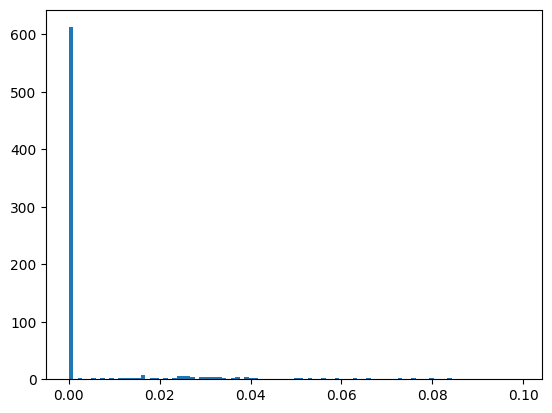

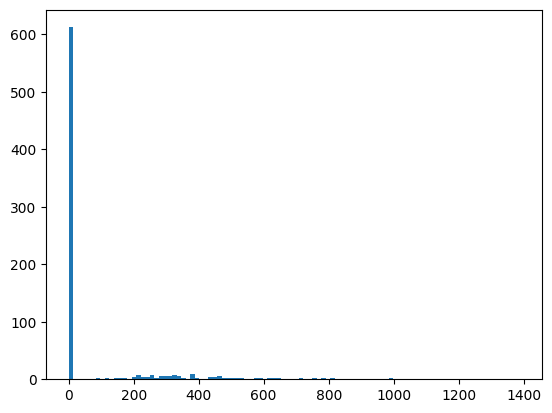

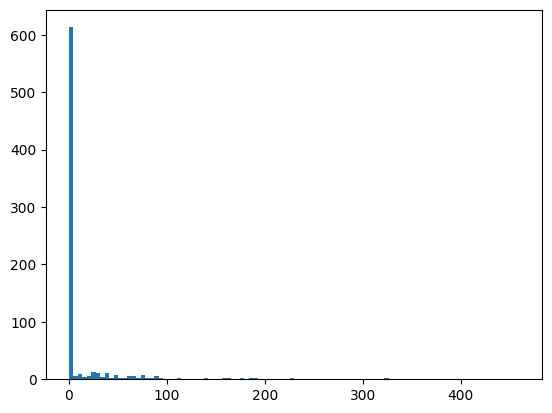

In [22]:
plt.hist(mse, bins=100)
plt.show()

plt.hist(tre, bins=100)
plt.show()

plt.hist(kp, bins=100)
plt.show()

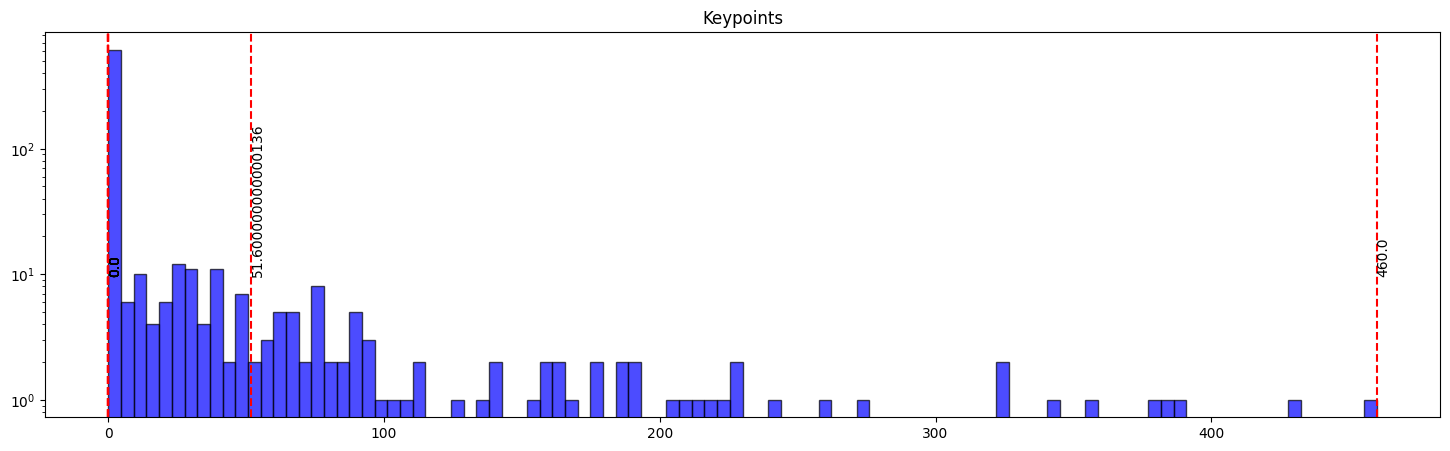

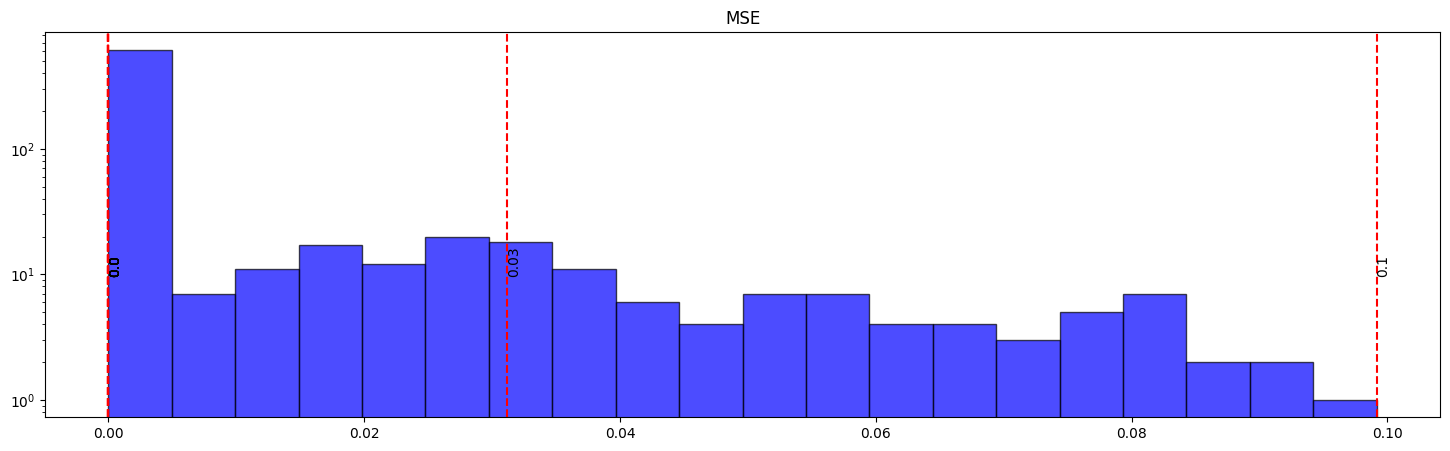

Text(0.5, 1.0, 'TRE')

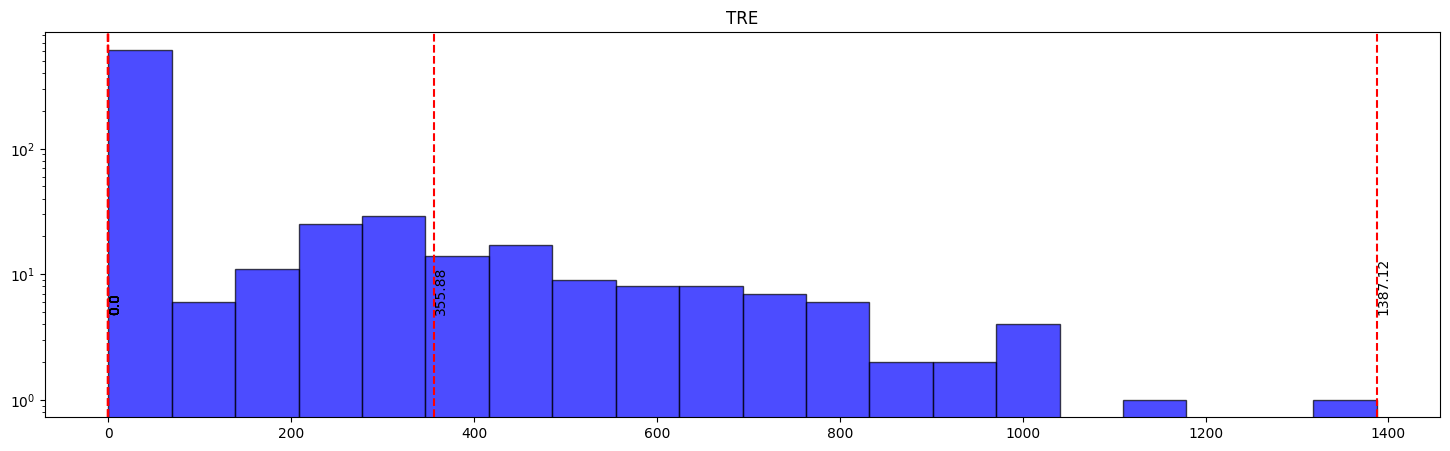

In [24]:
# show histogram with different colors for each 10% of mse, tre

kp_10 = np.percentile(kp, np.arange(0, 101, 10))
mse_10 = np.percentile(mse, np.arange(0, 101, 10))
tre_10 = np.percentile(tre, np.arange(0, 101, 10))

plt.figure(figsize=(18, 5))
plt.hist(kp, bins=100, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(kp_10)):
    plt.axvline(kp_10[i], color='red', linestyle='dashed')
    plt.text(kp_10[i], 10, str(kp_10[i]), rotation=90)
plt.title('Keypoints')
plt.yscale('log')
plt.show()

# show histogram with different colors for each 10% of mse, tre
plt.figure(figsize=(18, 5))
plt.hist(mse, bins=20, color='blue', alpha=0.7, edgecolor='black')

for i in range(1, len(mse_10)):
    plt.axvline(mse_10[i], color='red', linestyle='dashed')
    plt.text(mse_10[i], 10, str(round(mse_10[i], 2)), rotation=90)
plt.title('MSE')
plt.yscale('log')
plt.show()

plt.figure(figsize=(18, 5))
plt.hist(tre, bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(tre_10)):
    plt.axvline(tre_10[i], color='red', linestyle='dashed')
    plt.text(tre_10[i], 5, str(round(tre_10[i], 2)), rotation=90)
plt.yscale('log')
plt.title('TRE')


In [9]:
# get the value of mse, tre for each 10% of mse, tre
mse_10 = np.percentile(mse, np.arange(0, 101, 10))
tre_10 = np.percentile(tre, np.arange(0, 101, 10))

mse_10 = np.round(mse_10, 4)
tre_10 = np.round(tre_10, 4)

for i in range(len(mse_10) - 1):
    print(f'Percentile {i+1}: {mse_10[i]} - {mse_10[i+1]}, {tre_10[i]} - {tre_10[i+1]}')

Percentile 1: 0.0111 - 0.0161, 73.5935 - 214.4494
Percentile 2: 0.0161 - 0.0209, 214.4494 - 255.2256
Percentile 3: 0.0209 - 0.0253, 255.2256 - 301.7666
Percentile 4: 0.0253 - 0.0289, 301.7666 - 337.0486
Percentile 5: 0.0289 - 0.0323, 337.0486 - 385.6857
Percentile 6: 0.0323 - 0.0385, 385.6857 - 458.3133
Percentile 7: 0.0385 - 0.0492, 458.3133 - 523.383
Percentile 8: 0.0492 - 0.0595, 523.383 - 637.5244
Percentile 9: 0.0595 - 0.076, 637.5244 - 786.4615
Percentile 10: 0.076 - 0.0992, 786.4615 - 1384.7881


In [10]:
# percentile 30 and 70
mse_30 = np.percentile(mse, 30)
mse_70 = np.percentile(mse, 70)
tre_30 = np.percentile(tre, 30)
tre_70 = np.percentile(tre, 70)

print(f'Percentile 30: {mse_30}, {tre_30}')
print(f'Percentile 70: {mse_70}, {tre_70}')


Percentile 30: 0.02526697963476181, 301.76662992104957
Percentile 70: 0.04922133199870586, 523.3830258853379


In [11]:
# sort data by 'mse' and reset index
data = data.sort_values(by='mse').reset_index(drop=True)
data

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,mse,tre
0,224,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,0,0.011147,304.351770
1,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,0,0.011157,267.805900
2,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,0,0.011933,250.429631
3,442,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1R/b,0,0.011962,166.321977
4,435,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1R/b,0,0.012561,290.203377
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,22,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-15/c,0,0.084849,377.326119
136,413,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1R/b,0,0.089110,237.962182
137,554,Dataset/Dataset-processed/03-03-2560/3786536-1...,NaN,Dataset/Dataset-processed/03-03-2560/3786536-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3786536-1...,0,0.089572,301.716755
138,758,Dataset/Dataset-processed/30-12-2559/3236468/b...,NaN,Dataset/Dataset-processed/30-12-2559/3236468/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/30-12-2559/3236468/b,0,0.092977,322.488759


# sort image pair difficulty by number of matched keypoint pairs

In [31]:
# sort kp from smallest to largest
data = data.sort_values(by='keypoints').reset_index(drop=True)
data

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,mse,tre
0,2093,Dataset/Dataset-processed/10-08-2562/2960420-C...,NaN,Dataset/Dataset-processed/10-08-2562/2960420-C...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/10-08-2562/2960420-C...,0,0.000000,0.000000
1,3040,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,0,0.000000,0.000000
2,3041,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,0,0.000000,0.000000
3,3042,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,0,0.000000,0.000000
4,3043,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,240,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,379,0.004645,214.366509
759,233,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,382,0.006949,299.332591
760,235,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3220394-1...,388,0.002566,95.073656
761,568,Dataset/Dataset-processed/03-03-2560/3786536-1...,NaN,Dataset/Dataset-processed/03-03-2560/3786536-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/3786536-1...,429,0.025017,637.954544


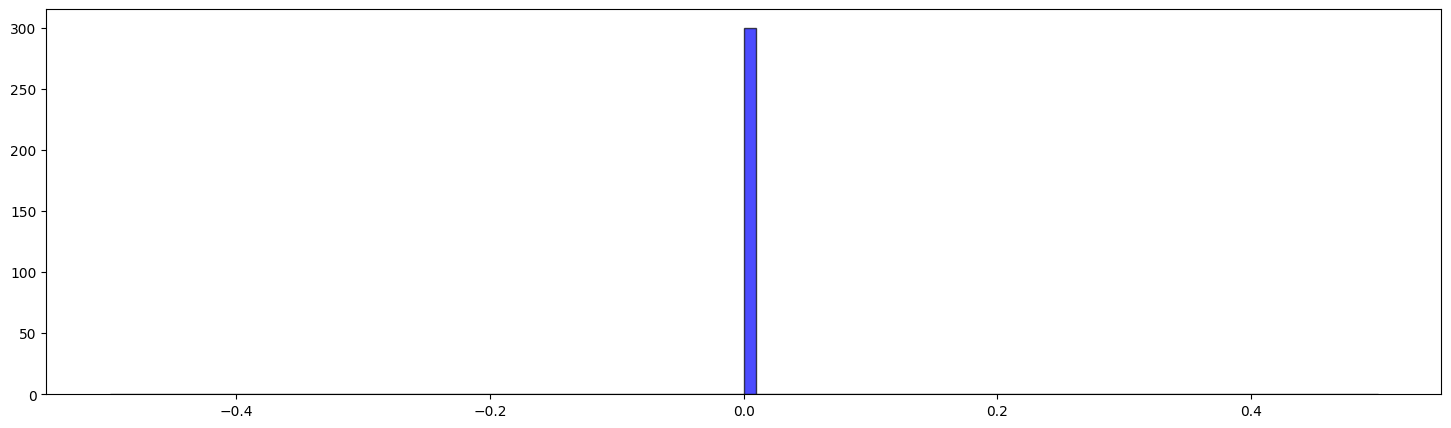

In [35]:
# histogram of 100 pairs with the least keypoints
plt.figure(figsize=(18, 5))
plt.hist(data['keypoints'][:300], bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.show()